# Skin Product Recommendation 

- Recommend top-3 skin products for your skin after skin type classification

In [1]:
%matplotlib inline

from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import cv2
import glob

# Construct the knowledge base about what products and skin types are available

- Gather all the available skin images and skin product info in database

## Load the skin product info

In [2]:
data_dir = '../data2/'
fs = ['11-06-2020_12-36-51_amazon_review_with_image_normal_imgfiles.csv',
     '11-06-2020_12-15-47_amazon_review_with_image_dry_imgfiles.csv',
      '11-06-2020_11-48-03_amazon_review_with_image_oily_imgfiles.csv']

# load into dataframes and concat them
df_fs = []
for f in fs:
    df_f = pd.read_csv('%s/%s' %(data_dir, f))
    df_fs.append(df_f)
df_fs = pd.concat(df_fs)
df_fs = df_fs.drop(columns=['Unnamed: 0'])

# print 
print(df_fs.shape)
df_fs.head(3)


(4442, 10)


,pid,ASIN,product_name,review,rating,img_link,skin_type,img_files,product_link,product_img
0,0,B01N9SPQHQ,La Roche-Posay Toleriane Double Repair Face Mo...,"Thankfully, I squeeze the lotion out onto my h...",1.0 out of 5 stars,https://images-na.ssl-images-amazon.com/images...,normal,"normal_B01N9SPQHQ_pid0_0,normal_B01N9SPQHQ_pid0_1",https://www.amazon.com/Roche-Posay-Toleriane-D...,https://images-na.ssl-images-amazon.com/images...
1,1,B01N9SPQHQ,La Roche-Posay Toleriane Double Repair Face Mo...,I used to use Physiogel lotion and cream both ...,5.0 out of 5 stars,https://images-na.ssl-images-amazon.com/images...,normal,"normal_B01N9SPQHQ_pid1_0,normal_B01N9SPQHQ_pid...",https://www.amazon.com/Roche-Posay-Toleriane-D...,https://images-na.ssl-images-amazon.com/images...
2,2,B01N9SPQHQ,La Roche-Posay Toleriane Double Repair Face Mo...,I bought this because I have Rosacea subtype 2...,5.0 out of 5 stars,https://images-na.ssl-images-amazon.com/images...,normal,"normal_B01N9SPQHQ_pid2_0,normal_B01N9SPQHQ_pid2_1",https://www.amazon.com/Roche-Posay-Toleriane-D...,https://images-na.ssl-images-amazon.com/images...


### Product info clean up
- Need the numerical score for the rating
- Did sentiment analysis with textblob but not in this version to avoid complexity
- The "skin_type" column determines whether that product is for dry, normal, or oily
- Remove duplicates

In [3]:
# rating parse the score
df_fs['rating_numerical'] = [float(s.split()[0]) for s in df_fs['rating'].tolist()]
df_fs.head(3)

,pid,ASIN,product_name,review,rating,img_link,skin_type,img_files,product_link,product_img,rating_numerical
0,0,B01N9SPQHQ,La Roche-Posay Toleriane Double Repair Face Mo...,"Thankfully, I squeeze the lotion out onto my h...",1.0 out of 5 stars,https://images-na.ssl-images-amazon.com/images...,normal,"normal_B01N9SPQHQ_pid0_0,normal_B01N9SPQHQ_pid0_1",https://www.amazon.com/Roche-Posay-Toleriane-D...,https://images-na.ssl-images-amazon.com/images...,1.0
1,1,B01N9SPQHQ,La Roche-Posay Toleriane Double Repair Face Mo...,I used to use Physiogel lotion and cream both ...,5.0 out of 5 stars,https://images-na.ssl-images-amazon.com/images...,normal,"normal_B01N9SPQHQ_pid1_0,normal_B01N9SPQHQ_pid...",https://www.amazon.com/Roche-Posay-Toleriane-D...,https://images-na.ssl-images-amazon.com/images...,5.0
2,2,B01N9SPQHQ,La Roche-Posay Toleriane Double Repair Face Mo...,I bought this because I have Rosacea subtype 2...,5.0 out of 5 stars,https://images-na.ssl-images-amazon.com/images...,normal,"normal_B01N9SPQHQ_pid2_0,normal_B01N9SPQHQ_pid2_1",https://www.amazon.com/Roche-Posay-Toleriane-D...,https://images-na.ssl-images-amazon.com/images...,5.0


In [13]:
# remove duplicate in case there are
print(df_fs.shape)
df_fs = df_fs.drop_duplicates(subset=['img_files'])
print(df_fs.drop_duplicates(subset=['img_files']).shape)

(4578, 9)
(4578, 9)


### Assign product info to each image file
- 'img_files' columns contains string with multiple image files separated by ',' 
- E.g., 'normal_B01N9SPQHQ_pid1_0,normal_B01N9SPQHQ_pid1_1,normal_B01N9SPQHQ_pid1_2'
- Need to split them and assign the same product info to each of them

In [4]:
df_new = []

# 'img_files' columns contains string with multiple image files 
for i in tqdm(range(0, df_fs.shape[0])):
    df_f = df_fs.iloc[i]
    imgs = df_f['img_files'].split(',')
    for img in imgs:
        tmp = df_f.copy(deep=True)
        tmp['img_file'] = img
        df_new.append(tmp)
        
# concat
df_new = pd.DataFrame(df_new)
df_new = df_new.drop(columns=['img_files'])
df_new = df_new.reset_index(drop=True)

# print
print(df_new.shape)
df_new.head(3)

<ipython-input-4-4de8375dee95>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(0, df_fs.shape[0])):



(6792, 11)


,pid,ASIN,product_name,review,rating,img_link,skin_type,product_link,product_img,rating_numerical,img_file
0,0,B01N9SPQHQ,La Roche-Posay Toleriane Double Repair Face Mo...,"Thankfully, I squeeze the lotion out onto my h...",1.0 out of 5 stars,https://images-na.ssl-images-amazon.com/images...,normal,https://www.amazon.com/Roche-Posay-Toleriane-D...,https://images-na.ssl-images-amazon.com/images...,1.0,normal_B01N9SPQHQ_pid0_0
1,0,B01N9SPQHQ,La Roche-Posay Toleriane Double Repair Face Mo...,"Thankfully, I squeeze the lotion out onto my h...",1.0 out of 5 stars,https://images-na.ssl-images-amazon.com/images...,normal,https://www.amazon.com/Roche-Posay-Toleriane-D...,https://images-na.ssl-images-amazon.com/images...,1.0,normal_B01N9SPQHQ_pid0_1
2,1,B01N9SPQHQ,La Roche-Posay Toleriane Double Repair Face Mo...,I used to use Physiogel lotion and cream both ...,5.0 out of 5 stars,https://images-na.ssl-images-amazon.com/images...,normal,https://www.amazon.com/Roche-Posay-Toleriane-D...,https://images-na.ssl-images-amazon.com/images...,5.0,normal_B01N9SPQHQ_pid1_0


## Load the image info
- I put all the available images from dry, normal, and oily into a new folder called images

In [5]:
img_fs = glob.glob('../data2/recommendation/images/*.jpg')
print('Number of available image:', len(img_fs))
print(img_fs[0:3])

Number of available image: 742
['../data2/recommendation/images/greyo0231_aug_0_9095.jpg', '../data2/recommendation/images/greyd0193_aug_0_7731.jpg', '../data2/recommendation/images/greyo0094_oily_faceimage399.jpg']


In [6]:
# identify which images are actually from the amazon product list bc there are images from other sources 
# E.g., greyd0004_dry_B00OW9OU2O_pid673_1.jpg -> only this part is relevant: 'dry_B00OW9OU2O_pid673_1'
imgs_amazon = []
for img_f in img_fs:
    # Get the part I care
    name = img_f.split('/')[-1]  
    name = name.split('_')[1:]
    
    # there should be four components in the img I need--
    # ['oily', 'B00BEUAZTG', 'pid1022', '0.jpg']. If not, do not include them in the list
    if len(name) == 4:
        name = "_".join(name).replace('.jpg',"")
        imgs_amazon.append(name)

# remove duplicates
imgs_amazon = list(set(imgs_amazon))

# check
print("Number of amazon product images:", len(imgs_amazon))
imgs_amazon[0:3]

Number of amazon product images: 430


['normal_B00JGQEVHC_pid579_0',
 'oily_B00BEUAZTG_pid1027_0',
 'dry_B00DG8EZKO_pid244_3']

## Reduce the size of the product info dataframe df_new based on what images are available


In [7]:
# Identify the image files that appear both in the product info as well as in the image list
imgs_amazon_comm = list(set(imgs_amazon) & set(df_new['img_file'].tolist()))
print('Amazon images that have both the product info and images:', len(imgs_amazon_comm))
imgs_amazon_comm[0:3]

Amazon images that have both the product info and images: 417


['oily_B00BEUAZTG_pid1027_0',
 'dry_B00DG8EZKO_pid244_3',
 'dry_B00BPF3LN2_pid649_0']

In [8]:
# Only get the product info that also has the images
df_new_comm = df_new[df_new['img_file'].isin(imgs_amazon_comm)]
df_new_comm = df_new_comm.set_index('img_file')

# print
print(df_new_comm.shape)
df_new_comm.head(3)

(417, 10)


,pid,ASIN,product_name,review,rating,img_link,skin_type,product_link,product_img,rating_numerical
img_file,,,,,,,,,,
normal_B01N9SPQHQ_pid2_0,2,B01N9SPQHQ,La Roche-Posay Toleriane Double Repair Face Mo...,I bought this because I have Rosacea subtype 2...,5.0 out of 5 stars,https://images-na.ssl-images-amazon.com/images...,normal,https://www.amazon.com/Roche-Posay-Toleriane-D...,https://images-na.ssl-images-amazon.com/images...,5.0
normal_B01N9SPQHQ_pid2_1,2,B01N9SPQHQ,La Roche-Posay Toleriane Double Repair Face Mo...,I bought this because I have Rosacea subtype 2...,5.0 out of 5 stars,https://images-na.ssl-images-amazon.com/images...,normal,https://www.amazon.com/Roche-Posay-Toleriane-D...,https://images-na.ssl-images-amazon.com/images...,5.0
normal_B01N9SPQHQ_pid3_0,3,B01N9SPQHQ,La Roche-Posay Toleriane Double Repair Face Mo...,"There I was.It was a Tuesday, mid October, 201...",5.0 out of 5 stars,https://images-na.ssl-images-amazon.com/images...,normal,https://www.amazon.com/Roche-Posay-Toleriane-D...,https://images-na.ssl-images-amazon.com/images...,5.0


In [9]:
# Some statistics..

# how many products for each skin type that can be possibly recommended
# *it's possible the same product appears in both oily and normal skin..
# which is okay because some products can be used in both skin type. as long as they yield good results(ratings)

for name, df_tmp in df_new_comm.groupby('skin_type'):
    print(name)
    print('Number of unique products:', len(set(df_tmp['ASIN'])))
    print(set(df_tmp['ASIN']))
    print()

dry
Number of unique products: 37
{'B0148PKYXU', 'B003QXZWYW', 'B00TTD9BRC', 'B086LJQNB2', 'B0017SWIU4', 'B00MMKAM5E', 'B07BRQC5XZ', 'B01NADTX4F', 'B00FAUS1HY', 'B07KYD25MF', 'B07YLJ2X55', 'B00OW9OU2O', 'B00ALB397Y', 'B01HDUOLQ8', 'B00NR1YQK4', 'B074MFDJRG', 'B00R3B58VA', 'B015ORMEP2', 'B072NBD1L1', 'B01FX1FAH8', 'B003BMJGKE', 'B000UBN5S8', 'B00AO1YZ60', 'B00WB8843Y', 'B00U97TO6U', 'B00BPF3LN2', 'B00YHZFA5E', 'B00DEX61A8', 'B01HWIEGAW', 'B086LJM3XH', 'B01B12KCGC', 'B00DG8EZKO', 'B000NWGCZ2', 'B018233T04', 'B001PBOKRM', 'B0046OFO3Y', 'B00143UYJE'}

normal
Number of unique products: 57
{'B01MR2YTKM', 'B00TTD9BRC', 'B077TQR6ZW', 'B07T9N7YLD', 'B0017SWIU4', 'B000052YOX', 'B003RF82UK', 'B00W4TW9BI', 'B01IAEVU3I', 'B01NADTX4F', 'B07VJH932Y', 'B001UTK76C', 'B07RJ18VMF', 'B07PNCCLD2', 'B009X62WM6', 'B00SNPCSUY', 'B077TWXCQV', 'B00KWX0M30', 'B001F51TBI', 'B01FA87072', 'B001IJ1PBK', 'B07Y92G633', 'B07Z5Z53CP', 'B00365DABC', 'B001ET79H8', 'B07CY3NXXM', 'B00U1YCRD8', 'B01D2M4G0C', 'B001P92FMG', 'B

## Load the product images into memory

In [10]:
# get all available images
img_fs = glob.glob('../data2/recommendation/images/*.jpg')

# identiy which path to get bc not all of the image paths is needed
# store in dictionary
img_fs_comm = {}
for f in img_fs:
    for i in imgs_amazon_comm:
        if i in f:
            img_fs_comm[i] = f
            
# loads the imgs
imgs = {}
for f in img_fs_comm.keys():
    img = cv2.imread(img_fs_comm[f])
    
    # perform similar preprocessing
    # grey scale: remove 3rd channel
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    
    # normalize to 0 and 255 (don't do 0 and 1 because the histogram comparison method need 0 and 255)
    # this will handle the difference in skin color better and focus more on the structure of the skin
    img = (img.max()-img)/(img.max()-img.min())*255
    
    # resize to (224,224)
    img = cv2.resize(img, (224,224), interpolation = cv2.INTER_LINEAR)
    # plt.imshow(img, cmap='gray')
     
    # assign
    imgs[f] = img


# Recommendation
- Recommend products based on similarity search
- Useda simple method called comparing histograms: https://stackoverflow.com/questions/11541154/how-can-i-assess-how-similar-two-images-are-with-opencv
- Note:
    - df_new_comm: product info
    - imgs: a dictionary of image ndarray (preprocessed)

## Preload a test image and assume we've made a classification..

In [11]:
img_test_classification = 'oily' # SHOULD GET THIS FROM CLASSIFICATION MODEL but just to test this recommender..
img_test_f = '../data2/recommendation/test/greyo0032_oily_B07D5GQ7RD_pid249_0.jpg'  #test image

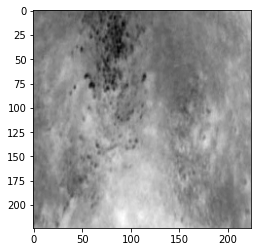

In [12]:
# preprocess
img_test = cv2.imread(img_test_f)

img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2GRAY) 

img_test = (img_test.max()-img_test)/(img_test.max()-img_test.min())*255

img_test = cv2.resize(img_test, (224,224), interpolation = cv2.INTER_LINEAR)
plt.imshow(img_test, cmap='gray')

In [34]:
img_test.shape

(224, 224)

## Search similar images in the database created
- since the label is only search only the oily related skin images and product
- reference: https://stackoverflow.com/questions/11541154/how-can-i-assess-how-similar-two-images-are-with-opencv
- https://stackoverflow.com/questions/40451706/how-to-use-comparehist-function-opencv

In [13]:
# select only the oily skin products
df_target = df_new_comm[df_new_comm['skin_type']==img_test_classification]

print(df_target.shape)
df_target.shape[0]

(161, 10)


161

In [14]:
# Compare the similarity between the test images and the datase images, and then output the 3 products with the highest rating

def compare_similarity(img1, img2):
    """
    :param img1 (numpy): width x height, grayscale image (0-255 pixel value)
    :param img2 (numpy): width x height, grayscale image (0-255 pixel value)
    """
    # Need to convert to uint8
    img1 = img1.astype('uint8')
    img1_hist = cv2.calcHist([img1], [0], None, [256], [0, 256])
    
    # Need to convert the to uint8
    img2= img2.astype('uint8')
    img2_hist = cv2.calcHist([img2], [0], None, [256], [0, 256])

    # calculate Bhattacharyya distance
    # https://docs.opencv.org/2.4/modules/imgproc/doc/histograms.html?highlight=comparehist
    # the smaller the better
    dist = cv2.compareHist(img1_hist, img2_hist, cv2.HISTCMP_BHATTACHARYYA)
    return dist, img1_hist, img2_hist

# Get the distance between the test image and all the other images
dists = {}
for imgf in tqdm(df_target.index):
    # get the database image
    img = imgs[imgf]

    # Compare the histogram of both the test image and the database image
    # Return a distance (similarity)
    dist, img1_hist, img2_hist = compare_similarity(img_test, img)
    # plt.hist(img1_hist)
    # plt.hist(img2_hist)
    
    # append
    dists[imgf] = dist
    
# sort the dict by value; return a list of tuple
dists_sorted = sorted(dists.items(), key=lambda kv: kv[1])

# check top 3 images
#plt.imshow(imgs[dists_sorted[0][0]], cmap='gray')
#plt.imshow(imgs[dists_sorted[1][0]], cmap='gray')
#plt.imshow(imgs[dists_sorted[2][0]], cmap='gray')

# output the top-3 working product to match your skin
k = 3
df_topk = [] 
for dist in dists_sorted :
    # Get the image-associated product
    df_tmp = df_target.loc[dist[0]]
    
    # if the product is good enough, then store the product
    # rating has to be at least 4
    if df_tmp['rating_numerical'] > 4.0:
        df_topk.append(df_tmp)
    
    # break if we have top three
    if len(df_topk) >= k:
        break
df_topk = pd.DataFrame(df_topk)        
    

<ipython-input-14-75e1202ff27b>:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for imgf in tqdm(df_target.index):


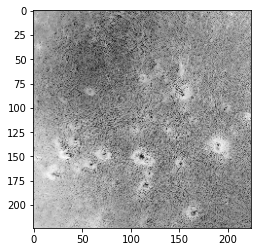

In [25]:
# check top 3 images
plt.imshow(imgs[dists_sorted[0][0]], cmap='gray')


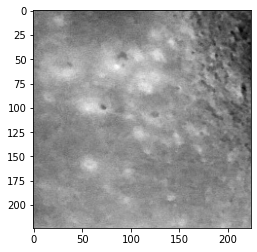

In [26]:
plt.imshow(imgs[dists_sorted[1][0]], cmap='gray')


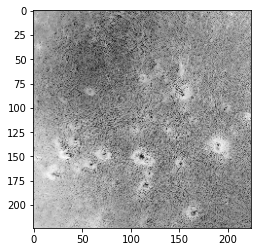

In [27]:
plt.imshow(imgs[dists_sorted[2][0]], cmap='gray')

In [29]:
dists

{'oily_B00NR1YQHM_pid51_0': 0.6068225028972287,
 'oily_B00NR1YQHM_pid51_1': 0.45419418241129056,
 'oily_B00NR1YQHM_pid54_0': 0.7565579690091452,
 'oily_B00NR1YQHM_pid62_0': 0.5981721604602919,
 'oily_B000052ZB8_pid73_0': 0.7455130475003146,
 'oily_B01H3YH882_pid77_0': 0.2808494406073897,
 'oily_B01H3YH882_pid80_0': 0.4727303843252231,
 'oily_B07D62CLYM_pid85_0': 0.40881361437255315,
 'oily_B07D62CLYM_pid85_1': 0.506224424940212,
 'oily_B07D62CLYM_pid85_2': 0.38960521755766064,
 'oily_B07D62CLYM_pid85_3': 0.4370985645019356,
 'oily_B00NR1YQKO_pid199_0': 0.16091193485055053,
 'oily_B00NR1YQKO_pid203_0': 0.585413815701027,
 'oily_B00NR1YQKO_pid208_0': 0.42618822652524235,
 'oily_B00F97FHAW_pid235_0': 0.40127529386037036,
 'oily_B00F97FHAW_pid235_1': 0.7489439795388512,
 'oily_B00F97FHAW_pid245_0': 0.6118584494617323,
 'oily_B00F97FHAW_pid246_0': 0.4207696379774791,
 'oily_B00F97FHAW_pid247_0': 0.27322221383927203,
 'oily_B00F97FHAW_pid248_0': 0.40164181437428964,
 'oily_B07D5GQ7RD_pid249_

In [15]:
# top-3 product for this test image
df_topk

,pid,ASIN,product_name,review,rating,img_link,skin_type,product_link,product_img,rating_numerical
oily_B07D5GQ7RD_pid249_0,249,B07D5GQ7RD,Neutralyze Renewal Complex | Maximum Strength ...,I would call this as Magic Potion! It really w...,5.0 out of 5 stars,https://images-na.ssl-images-amazon.com/images...,oily,https://www.amazon.com/Neutralyze-Renewal-Comp...,https://images-na.ssl-images-amazon.com/images...,5.0
oily_B00YHZFA5E_pid1796_0,1796,B00YHZFA5E,Puriya Intensive Moisturizing Cream for Sensit...,I’ve been suffering from “Perioral Dermatitis”...,5.0 out of 5 stars,https://images-na.ssl-images-amazon.com/images...,oily,https://www.amazon.com/Puriya-Psoriasis-Dermat...,https://images-na.ssl-images-amazon.com/images...,5.0
oily_B00949CTQQ_pid1705_2,1705,B00949CTQQ,Paulas Choice--SKIN PERFECTING 2% BHA Liquid S...,Wow. This product is incredible. I have never ...,5.0 out of 5 stars,https://images-na.ssl-images-amazon.com/images...,oily,https://www.amazon.com/Paulas-Choice-SKIN-PERF...,https://images-na.ssl-images-amazon.com/images...,5.0


In [16]:
df_topk['product_name'][0]

'Neutralyze Renewal Complex | Maximum Strength Anti Acne + Anti Aging Moisturizer Cream With Time-Released 2% Salicylic Acid + 1% Mandelic Acid + Nitrogen Boost Skincare Technology (3.4 oz)'

In [52]:
df_topk['product_name'].tolist()

['Neutralyze Renewal Complex | Maximum Strength Anti Acne + Anti Aging Moisturizer Cream With Time-Released 2% Salicylic Acid + 1% Mandelic Acid + Nitrogen Boost Skincare Technology (3.4 oz)',
 'Puriya Intensive Moisturizing Cream for Sensitive and Irritated Skin, Dermatologist Reviewed, Clinically Tested Plant Rich Formula, Soothes Rough, Dry, Scaly Patches, Trusted by 300,000 Families',
 'Paulas Choice--SKIN PERFECTING 2% BHA Liquid Salicylic Acid Exfoliant--Facial Exfoliant for Blackheads, Enlarged Pores, Wrinkles & Fine Lines, 4 oz Bottle']

In [53]:
df_topk['rating_numerical'].tolist()

[5.0, 5.0, 5.0]

In [38]:
product_img = df_topk['product_img'].tolist()

In [39]:
product_img

['https://images-na.ssl-images-amazon.com/images/I/71ACiELY7sL._SL1500_.jpg',
 'https://images-na.ssl-images-amazon.com/images/I/71Lu3oE4oBL._AC_SL1500_.jpg',
 'https://images-na.ssl-images-amazon.com/images/I/61L0IlgrfzL._SL1500_.jpg']

In [28]:
for x in range(len(product_img)): 
    print (product_img[x])

https://images-na.ssl-images-amazon.com/images/I/71ACiELY7sL._SL1500_.jpg
https://images-na.ssl-images-amazon.com/images/I/71Lu3oE4oBL._AC_SL1500_.jpg
https://images-na.ssl-images-amazon.com/images/I/61L0IlgrfzL._SL1500_.jpg


In [40]:
print(product_img[0])

https://images-na.ssl-images-amazon.com/images/I/71ACiELY7sL._SL1500_.jpg
